In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

np.random.seed(42)

In [3]:
wires = 6
dev = qml.device("lightning.qubit", wires=wires, shots=10000)

In [4]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return qml.probs(wires=range(wires))

def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    return [qml.probs(wires=i) for i in range(wires)]

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - np.sum([i for (i, _) in local_circuit(rotations)])/wires


def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

In [5]:
RX = np.random.uniform(low=-np.pi, high=np.pi)
RY = np.random.uniform(low=-np.pi, high=np.pi)
rotations = [[RX for i in range(wires)], [RY for i in range(wires)]]

Global Cost:  1.0000000
Local Cost:  0.8356167


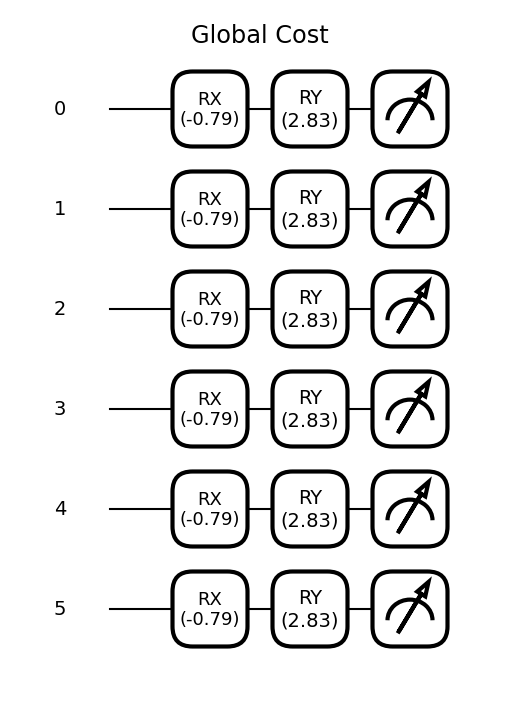

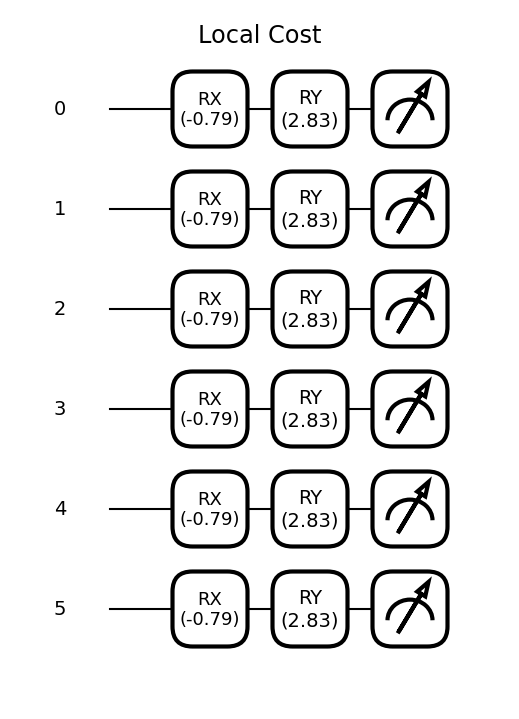

In [6]:
print("Global Cost: {: .7f}".format(cost_global(rotations)))
print("Local Cost: {: .7f}".format(cost_local(rotations)))

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(global_circuit, decimals=2)(rotations)
fig1.suptitle("Global Cost", fontsize='xx-large')
plt.show()

fig2, ax2 = qml.draw_mpl(local_circuit, decimals=2)(rotations)
fig2.suptitle("Local Cost", fontsize='xx-large')
plt.show()

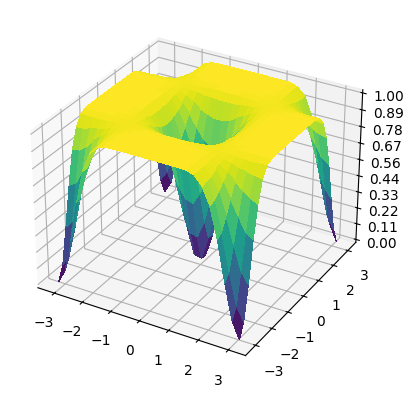

In [7]:
def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)

    for x in X[0, :]:
        for y in Y[:, 0]:
            rotations = [[x for i in range(wires)], [y for i in range(wires)]]
            Z_assembler.append(cost_function(rotations))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(-np.pi, np.pi, 0.25)
    Y = np.arange(-np.pi, np.pi, 0.25)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=False)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    plt.show()


global_surface = generate_surface(cost_global)
plot_surface(global_surface)

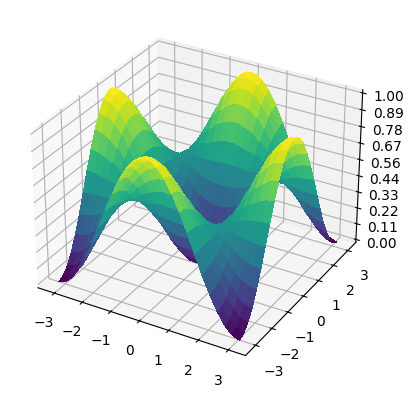

In [8]:
local_surface = generate_surface(cost_local)
plot_surface(local_surface)

In [10]:
def global_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=range(wires))
def local_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(wires=[0])

global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

local_circuit = qml.QNode(local_cost_simple, dev, interface="autograd")

def cost_local(rotations):
    return 1 - local_circuit(rotations)[0]
def cost_global(rotations):
    return 1 - global_circuit(rotations)[0]

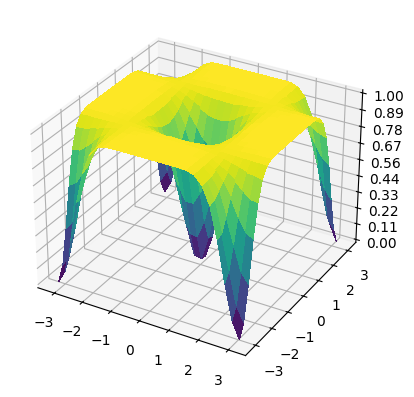

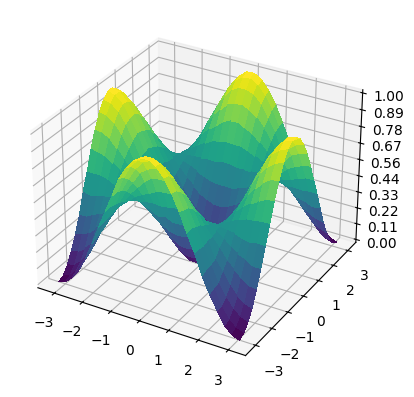

In [11]:
global_surface = generate_surface(cost_global)
plot_surface(global_surface)

local_surface = generate_surface(cost_local)
plot_surface(local_surface)

In [ ]:
rotations = np.array([[3.] * len(range(wires)), [0.] * len(range(wires))], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_global = rotations
for i in range(steps):
    # update the circuit parameters
    params_global = opt.step(cost_global, params_global)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
    if cost_global(params_global) < 0.1:
        break
fig, ax = qml.draw_mpl(global_circuit, decimals=2)(params_global)
plt.show()

In [ ]:
rotations = np.array([[3. for i in range(wires)], [0. for i in range(wires)]], requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 100
params_local = rotations
for i in range(steps):
    # update the circuit parameters
    params_local = opt.step(cost_local, params_local)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_local(params_local)))
    if cost_local(params_local) < 0.05:
        break

fig, ax = qml.draw_mpl(local_circuit, decimals=2)(params_local)
plt.show()

In [ ]:
cost_global(params_local)

In [ ]:
dev.shots = None
global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")
print(
    "Current cost: "
    + str(cost_global(params_local))
    + ".\nInitial cost: "
    + str(cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]]))
    + ".\nDifference: "
    + str(
        cost_global([[3.0 for i in range(wires)], [0 for i in range(wires)]])
        - cost_global(params_local)
    )
)

In [ ]:
def tunable_cost_simple(rotations):
    for i in range(wires):
        qml.RX(rotations[0][i], wires=i)
        qml.RY(rotations[1][i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    return qml.probs(range(locality))

def cost_tunable(rotations):
    return 1 - tunable_circuit(rotations)[0]

dev.shots = 10000
tunable_circuit = qml.QNode(tunable_cost_simple, dev, interface="autograd")
locality = 2
params_tunable = params_local
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()
print(cost_tunable(params_tunable))

locality = 2
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 600
for i in range(steps):
    # update the circuit parameters
    params_tunable = opt.step(cost_tunable, params_tunable)

    runCost = cost_tunable(params_tunable)
    if (i + 1) % 10 == 0:
        print(
            "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
            + ". Locality: "
            + str(locality)
        )

    if runCost < 0.1 and locality < wires:
        print("---Switching Locality---")
        locality += 1
        continue
    elif runCost < 0.1 and locality >= wires:
        break
fig, ax = qml.draw_mpl(tunable_circuit, decimals=2)(params_tunable)
plt.show()

In [ ]:
samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 400
wires = 8

dev = qml.device("lightning.qubit", wires=wires, shots=10000)
global_circuit = qml.QNode(global_cost_simple, dev, interface="autograd")

for runs in range(samples):
    print("--- New run! ---")
    has_been_trained = False

    params_global = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)

    for i in range(steps):
        # update the circuit parameters
        params_global = opt.step(cost_global, params_global)

        if (i + 1) % 20 == 0:
            print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_global(params_global)))
        if cost_global(params_global) < 0.9:
            has_been_trained = True
            break
    if has_been_trained:
        trained = trained + 1
    else:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))


samples = 10
plateau = 0
trained = 0
opt = qml.GradientDescentOptimizer(stepsize=0.2)
steps = 400
wires = 8

dev = qml.device("lightning.qubit", wires=wires, shots=10000)
tunable_circuit = qml.QNode(tunable_cost_simple, dev, interface="autograd")

for runs in range(samples):
    locality = 1
    print("--- New run! ---")
    has_been_trained = False

    params_tunable = np.random.uniform(-np.pi, np.pi, (2, wires), requires_grad=True)
    for i in range(steps):
        # update the circuit parameters
        params_tunable = opt.step(cost_tunable, params_tunable)

        runCost = cost_tunable(params_tunable)
        if (i + 1) % 10 == 0:
            print(
                "Cost after step {:5d}: {: .7f}".format(i + 1, runCost)
                + ". Locality: "
                + str(locality)
            )

        if runCost < 0.5 and locality < wires:
            print("---Switching Locality---")
            locality += 1
            continue
        elif runCost < 0.1 and locality >= wires:
            trained = trained + 1
            has_been_trained = True
            break
    if not has_been_trained:
        plateau = plateau + 1
    print("Trained: {:5d}".format(trained))
    print("Plateau'd: {:5d}".format(plateau))